#### Run relevance backout here

In [200]:
import pickle
import re
import os

import random
import numpy as np
import torch
from random import shuffle
import argparse
import pickle

import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sys
sys.path.append("..")

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from tqdm import tqdm, trange

from util.optimization import BERTAdam
from util.processor import *


from util.tokenization import *

from util.evaluation import *

from util.train_helper import *

import logging
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

from sklearn.metrics import classification_report

# this imports most of the helpers needed to eval the model
from run_classifier import *

sys.path.append("..")
import operator

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

RETRAIN = False
vocab_data_dir = "../../models/BERT-Google/vocab.txt"

In [201]:
import torch
import torch.nn as nn
import numpy as np
from numpy import newaxis as na


##############################################################################
#
# The function to back-out layerwise attended relevance scores.
#
##############################################################################
def rescale_lrp(post_A, inp_relevances):
    inp_relevances = torch.abs(inp_relevances)
    if len(post_A.shape) == 2:
        ref_scale = torch.sum(post_A, dim=-1, keepdim=True) + 1e-7
        inp_scale = torch.sum(inp_relevances, dim=-1, keepdim=True) + 1e-7
    elif len(post_A.shape) == 3:
        ref_scale = post_A.sum(dim=-1, keepdim=True).sum(dim=-1, keepdim=True) + 1e-7
        inp_scale = inp_relevances.sum(dim=-1, keepdim=True).sum(dim=-1, keepdim=True) + 1e-7
    scaler = ref_scale / inp_scale
    inp_relevances = inp_relevances * scaler
    return inp_relevances

def backprop_lrp_fc(weight, bias, activations, R, 
                    eps=1e-7, alpha=0.5, debug=False):
    beta = 1.0 - alpha
    
    weight_p = torch.clamp(weight, min=0.0)
    bias_p = torch.clamp(bias, min=0.0)    
    z_p = torch.matmul(activations, weight_p.T) + bias_p + eps
    s_p = R / z_p
    c_p = torch.matmul(s_p, weight_p)
    
    weight_n = torch.clamp(weight, max=0.0)
    bias_n = torch.clamp(bias, max=0.0)
    z_n = torch.matmul(activations, weight_n.T) + bias_n - eps 
    s_n = R / z_n
    c_n = torch.matmul(s_n, weight_n)

    R_c = activations * (alpha * c_p + beta * c_n)
    
    R_c = rescale_lrp(R, R_c)

    return R_c

def backprop_lrp_nl(weight, activations, R, 
                    eps=1e-7, alpha=0.5, debug=False):
    """
    This is for non-linear linear lrp.
    We use jacobian and first term of Taylor expansions.
    weight: [b, l, h_out, h_in]
    activations: [b, l, h_in]
    R: [b, l, h_out]
    """
    beta = 1.0 - alpha
    R = R.unsqueeze(dim=2) # [b, l, 1, h_out]
    activations = activations.unsqueeze(dim=2) # [b, l, 1, h_in]

    weight_p = torch.clamp(weight, min=0.0) 
    z_p = torch.matmul(activations, weight_p.transpose(2,3)) + eps
    s_p = R / z_p # [b, l, 1, h_out]
    c_p = torch.matmul(s_p, weight_p) # [b, l, 1, h_in]
    
    weight_n = torch.clamp(weight, max=0.0)
    z_n = torch.matmul(activations, weight_n.transpose(2,3)) + eps 
    s_n = R / z_n
    c_n = torch.matmul(s_n, weight_n)

    R_c = activations * (alpha * c_p + beta * c_n)
    
    R_c = R_c.squeeze(dim=2)
    R = R.squeeze(dim=2)
    R_c = rescale_lrp(R, R_c)

    return R_c

def rescale_jacobian(output_relevance, *input_relevances, batch_axes=(0,)):
    assert isinstance(batch_axes, (tuple, list))
    get_summation_axes = lambda tensor: tuple(i for i in range(len(tensor.shape)) if i not in batch_axes)
    ref_scale = abs(output_relevance).sum(dim=get_summation_axes(output_relevance), keepdim=True)
    inp_scales = [abs(inp).sum(dim=get_summation_axes(inp), keepdim=True) for inp in input_relevances]
    total_inp_scale = sum(inp_scales) + 1e-7
    input_relevances = [inp * (ref_scale / total_inp_scale) for inp in input_relevances]
    return input_relevances[0] if len(input_relevances) == 1 else input_relevances

def backprop_lrp_jacobian(jacobians, output, R, inps, eps=1e-7, alpha=0.5, batch_axes=(0,)):
    """
    computes input relevance given output_relevance using z+ rule
    works for linear layers, convolutions, poolings, etc.
    notation from DOI:10.1371/journal.pone.0130140, Eq 60
    """
    
    beta = 1.0 - alpha
    inps = [inp for inp in inps]

    reference_inputs = tuple(map(torch.zeros_like, inps))
    assert len(reference_inputs) == len(inps)

    flat_output_relevance = R.reshape([-1])
    output_size = flat_output_relevance.shape[0]

    assert len(jacobians) == len(inps)

    jac_flat_components = [jac.reshape([output_size, -1]) for jac in jacobians]
    # ^-- list of [output_size, input_size] for each input
    flat_jacobian = torch.cat(jac_flat_components, dim=-1)  # [output_size, combined_input_size]

    # 2. multiply jacobian by input to get unnormalized relevances, add bias
    flat_input = torch.cat([inp.reshape([-1]) for inp in inps], dim=-1)  # [combined_input_size]
    flat_reference_input = torch.cat([ref.reshape([-1]) for ref in reference_inputs], dim=-1)
    import operator
    from functools import reduce 
    num_samples = reduce(operator.mul, [output.shape[batch_axis] for batch_axis in batch_axes], 1)
    input_size_per_sample = flat_reference_input.shape[0] // num_samples
    flat_impact = (flat_jacobian * flat_input[None, :])
    # ^-- [output_size, combined_input_size], aka z_{j<-i}

    # 3. normalize positive and negative relevance separately and add them with coefficients
    flat_positive_impact = torch.clamp(flat_impact, min=0.0)
    flat_positive_normalizer = flat_positive_impact.sum(dim=0, keepdim=True) + eps
    flat_positive_relevance = flat_positive_impact / flat_positive_normalizer

    flat_negative_impact = torch.clamp(flat_impact, max=0.0)
    flat_negative_normalizer = flat_negative_impact.sum(dim=0, keepdim=True) - eps
    flat_negative_relevance = flat_negative_impact / flat_negative_normalizer
    flat_total_relevance_transition = alpha * flat_positive_relevance + beta * flat_negative_relevance

    flat_input_relevance = torch.einsum('o,oi->i', flat_output_relevance, flat_total_relevance_transition)
    # ^-- [combined_input_size]

    # 5. unpack flat_inp_relevance back into individual tensors
    input_relevances = []
    offset = 0
    for inp in inps:
        inp_size = inp.reshape([-1]).shape[0]
        inp_relevance = flat_input_relevance[offset: offset + inp_size].reshape(inp.shape)
        inp_relevance = inp_relevance.contiguous()
        input_relevances.append(inp_relevance)
        offset = offset + inp_size
    
    return rescale_jacobian(R, *input_relevances, batch_axes=batch_axes)

In [272]:
# coding=utf-8

# Reference: https://github.com/huggingface/pytorch-pretrained-BERT

"""PyTorch BERT model."""

from __future__ import absolute_import, division, print_function

import copy
import json
import math

import six
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss

import collections
from functools import partial

from util.lrp import *

# access global vars here
global func_inputs
global func_activations
func_inputs = collections.defaultdict(list)
func_activations = collections.defaultdict(list)

def get_inputivation(name):
    def hook(model, input, output):
        func_inputs[name] = [_in for _in in input]
    return hook

def get_activation(name):
    def hook(model, input, output):
        func_activations[name] = output
    return hook

def get_activation_multi(name):
    def hook(model, input, output):
        func_activations[name] = [_out for _out in output]
    return hook

# TODO: make this init as a part of the model init
def init_hooks_lrp(model):
    """
    Initialize all the hooks required for full lrp for BERT model.
    """
    # in order to backout all the lrp through layers
    # you need to register hooks here.

    model.classifier.register_forward_hook(
        get_inputivation('model.classifier'))
    model.classifier.register_forward_hook(
        get_activation('model.classifier'))
    model.bert.pooler.dense.register_forward_hook(
        get_inputivation('model.bert.pooler.dense'))
    model.bert.pooler.dense.register_forward_hook(
        get_activation('model.bert.pooler.dense'))
    model.bert.pooler.register_forward_hook(
        get_inputivation('model.bert.pooler'))
    model.bert.pooler.register_forward_hook(
        get_activation('model.bert.pooler'))

    model.bert.embeddings.word_embeddings.register_forward_hook(
        get_activation('model.bert.embeddings.word_embeddings'))
    model.bert.embeddings.register_forward_hook(
        get_activation('model.bert.embeddings'))

    layer_module_index = 0
    for module_layer in model.bert.encoder.layer:
        
        ## Encoder Output Layer
        layer_name_output_layernorm = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.output.LayerNorm'
        module_layer.output.LayerNorm.register_forward_hook(
            get_inputivation(layer_name_output_layernorm))

        layer_name_dense = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.output.dense'
        module_layer.output.dense.register_forward_hook(
            get_inputivation(layer_name_dense))
        module_layer.output.dense.register_forward_hook(
            get_activation(layer_name_dense))

        layer_name_output = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.output'
        module_layer.output.register_forward_hook(
            get_inputivation(layer_name_output))
        module_layer.output.register_forward_hook(
            get_activation(layer_name_output))
        
        ## Encoder Intermediate Layer
        layer_name_inter = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.intermediate.dense'
        module_layer.intermediate.dense.register_forward_hook(
            get_inputivation(layer_name_inter))
        module_layer.intermediate.dense.register_forward_hook(
            get_activation(layer_name_inter))

        layer_name_attn_layernorm = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.attention.output.LayerNorm'
        module_layer.attention.output.LayerNorm.register_forward_hook(
            get_inputivation(layer_name_attn_layernorm))
        
        layer_name_attn = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.attention.output.dense'
        module_layer.attention.output.dense.register_forward_hook(
            get_inputivation(layer_name_attn))
        module_layer.attention.output.dense.register_forward_hook(
            get_activation(layer_name_attn))

        layer_name_attn_output = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.attention.output'
        module_layer.attention.output.register_forward_hook(
            get_inputivation(layer_name_attn_output))
        module_layer.attention.output.register_forward_hook(
            get_activation(layer_name_attn_output))
        
        layer_name_self = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.attention.self'
        module_layer.attention.self.register_forward_hook(
            get_inputivation(layer_name_self))
        module_layer.attention.self.register_forward_hook(
            get_activation_multi(layer_name_self))

        layer_name_value = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.attention.self.value'
        module_layer.attention.self.value.register_forward_hook(
            get_inputivation(layer_name_value))
        module_layer.attention.self.value.register_forward_hook(
            get_activation(layer_name_value))

        layer_name_query = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.attention.self.query'
        module_layer.attention.self.query.register_forward_hook(
            get_inputivation(layer_name_query))
        module_layer.attention.self.query.register_forward_hook(
            get_activation(layer_name_query))

        layer_name_key = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.attention.self.key'
        module_layer.attention.self.key.register_forward_hook(
            get_inputivation(layer_name_key))
        module_layer.attention.self.key.register_forward_hook(
            get_activation(layer_name_key))
        
        layer_module_index += 1

def gelu(x):
    """Implementation of the gelu activation function.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


class BertConfig(object):
    """Configuration class to store the configuration of a `BertModel`.
    """
    def __init__(self,
                vocab_size=32000,
                hidden_size=768,
                num_hidden_layers=12,
                num_attention_heads=12,
                intermediate_size=3072,
                hidden_act="gelu",
                hidden_dropout_prob=0.1,
                attention_probs_dropout_prob=0.1,
                max_position_embeddings=512,
                type_vocab_size=16,
                initializer_range=0.02,
                full_pooler=False): # this is for transformer-like BERT
        """Constructs BertConfig.

        Args:
            vocab_size: Vocabulary size of `inputs_ids` in `BertModel`.
            hidden_size: Size of the encoder layers and the pooler layer.
            num_hidden_layers: Number of hidden layers in the Transformer encoder.
            num_attention_heads: Number of attention heads for each attention layer in
                the Transformer encoder.
            intermediate_size: The size of the "intermediate" (i.e., feed-forward)
                layer in the Transformer encoder.
            hidden_act: The non-linear activation function (function or string) in the
                encoder and pooler.
            hidden_dropout_prob: The dropout probabilitiy for all fully connected
                layers in the embeddings, encoder, and pooler.
            attention_probs_dropout_prob: The dropout ratio for the attention
                probabilities.
            max_position_embeddings: The maximum sequence length that this model might
                ever be used with. Typically set this to something large just in case
                (e.g., 512 or 1024 or 2048).
            type_vocab_size: The vocabulary size of the `token_type_ids` passed into
                `BertModel`.
            initializer_range: The sttdev of the truncated_normal_initializer for
                initializing all weight matrices.
        """
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.hidden_act = hidden_act
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range
        self.full_pooler = full_pooler

    @classmethod
    def from_dict(cls, json_object):
        """Constructs a `BertConfig` from a Python dictionary of parameters."""
        config = BertConfig(vocab_size=None)
        for (key, value) in six.iteritems(json_object):
            config.__dict__[key] = value
        return config

    @classmethod
    def from_json_file(cls, json_file):
        """Constructs a `BertConfig` from a json file of parameters."""
        with open(json_file, "r") as reader:
            text = reader.read()
        return cls.from_dict(json.loads(text))

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"
    
class BERTLayerNorm(nn.Module):
    def __init__(self, config, variance_epsilon=1e-12):
        """Construct a layernorm module in the TF style (epsilon inside the square root).
        """
        super(BERTLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(config.hidden_size))
        self.beta = nn.Parameter(torch.zeros(config.hidden_size))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta

class BERTEmbeddings(nn.Module):
    def __init__(self, config):
        super(BERTEmbeddings, self).__init__()
        """Construct the embedding module from word, position and token_type embeddings.
        """
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = BERTLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids, token_type_ids=None):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

    def backward_lrp(self, relevance_score):
        # we use the whole embedding as its units
        return relevance_score

class BERTSelfAttention(nn.Module):
    def __init__(self, config):
        super(BERTSelfAttention, self).__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads))
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def transpose_for_context(self, x):
        new_x_shape = x.size()[:2] + \
            (self.num_attention_heads, self.attention_head_size,)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3).contiguous()

    def transpose_for_value(self, x):
        x = x.permute(0, 2, 1, 3).contiguous()
        new_x_shape = x.size()[:2] + (self.all_head_size,)
        return x.view(*new_x_shape)

    def forward(self, hidden_states, attention_mask):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        return context_layer, attention_probs
    
    def attention_core(self, query_layer, key_layer, value_layer, attention_mask):
        """
        This is the core self-attention layer.
        """
        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)
        
        return attention_probs
    
    def jacobian(self, tensor_out, tensor_in, debug=False):
        """
        This is super slow. You can simply write out the full
        jacboian by hand, and it would be so much faster.
        PyTorch team is working on a fastor impl which is still
        in progress.
        """
        import time
        start = time.time()
        jacobian_full = []
        for i in range(tensor_out.shape[2]):
            jac_mask = torch.zeros_like(tensor_out)
            jac_mask[:,:,i] = 1.
            jacobian_partial = torch.autograd.grad(tensor_out, tensor_in,
                                                   grad_outputs=jac_mask,
                                                   retain_graph=True)[0]
            jacobian_full.append(jacobian_partial)
        jacobian_full = torch.stack(jacobian_full, dim=2)
        end = time.time()
        if debug:
            print(jacobian_full.shape)
            print("Time Elapse for 1 Jacobian Full: ", end - start)
        return jacobian_full

    def _attn_head_jacobian(self, q, k, v, attn_mask):
        """ 
        same as jacobian above, but faster 
        referene code: 
        https://github.com/lena-voita/the-story-of-heads/blob/master/lib/layers/attn_lrp.py
        """
        # input shapes: (q, k, v) - [batch_size, n_q or n_kv, dim per head]
        # attn_head_mask: [batch_size, n_q, n_kv]
        assert len(q.shape) == 3 and len(attn_mask.shape) == 3
        
        ATTN_BIAS_VALUE = -1e9
        key_depth_per_head = float(q.shape[-1])
        q = q / (key_depth_per_head ** 0.5)

        attn_bias = ATTN_BIAS_VALUE * (1 - attn_mask)
        logits = torch.matmul(q, k.permute(0,2,1)) + attn_bias
        weights = nn.Softmax(dim=-1)(logits)  # [batch_size, n_q, n_kv]
        out = torch.matmul(weights, v)  # [batch_size, n_q, dim/n_heads]

        batch_size, n_kv, dim_per_head = v.shape[0], v.shape[1], v.shape[2]

        diag_flat_weights = torch.einsum('ij,jqk->iqjk', 
                                         torch.eye(weights.shape[0]), weights)  # [b, n_q, b, n_kv]
        flat_jac_v = diag_flat_weights[:, :, None, :, :, None] * \
                        torch.eye(dim_per_head)[None, None, :, None, None, :]
        # ^-- shape: [batch_size, n_q, dim/h, batch_size, n_kv, dim/h]
        # torch.Size([1, 48, 64, 1, 48, 64])

        # ... just to get around this torch.tile(v[:, None], [1, out.shape[1], 1, 1])
        jac_out_wrt_weights = torch.cat(out.shape[1]*[v[:, None]], dim=1) 
        jac_out_wrt_weights = jac_out_wrt_weights.permute([0, 1, 3, 2])
        # ^-- [batch_size, n_q, (dim), (n_kv)]
        
        softmax_jac = (weights[..., None] * torch.eye(weights.shape[-1])
                       - weights[..., None, :] * weights[..., :, None])  # <-- [batch_size, n_q, n_kv, n_kv]
        jac_out_wrt_logits = jac_out_wrt_weights @ softmax_jac  # [batch_size, n_q, (dim), (n_kv)]

        jac_out_wrt_k = jac_out_wrt_logits[..., None] * q[:, :, None, None, :]  # [b, (n_q, dim), (n_kv, dim)]
        
        # product axes:                    b  q  d  kv   d       b  q      d    kv d
        jac_out_wrt_q = jac_out_wrt_logits[:, :, :, :, None] * k[:, None, None, :, :]
        jac_out_wrt_q = jac_out_wrt_q.sum(dim=3, keepdim=True)
        jac_out_wrt_q = jac_out_wrt_q / float(key_depth_per_head) ** 0.5
        jac_out_wrt_q = jac_out_wrt_q * torch.eye(jac_out_wrt_q.shape[1])[None, :, None, :, None]

        flat_jac_k = jac_out_wrt_k[..., None, :, :] * torch.eye(q.shape[0])[:, None, None, :, None, None]
        flat_jac_q = jac_out_wrt_q[..., None, :, :] * torch.eye(q.shape[0])[:, None, None, :, None, None]
        # final shape of flat_jac_{q, k}: [(batch_size, n_q, dim), (batch_size, n_kv, dim)]

        return flat_jac_q, flat_jac_k, flat_jac_v
    
    def backward_lrp(self, relevance_score, layer_module_index, lrp_detour="quick"):
        """
        This is the lrp explicitily considering the attention layer.
        """

        layer_name_value = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.attention.self.value'
        layer_name_query = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.attention.self.query'
        layer_name_key = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.attention.self.key'
        value_in = func_inputs[layer_name_value][0]
        value_out = func_activations[layer_name_value]
        query_in = func_inputs[layer_name_query][0]
        query_out = func_activations[layer_name_query]
        key_in = func_inputs[layer_name_key][0]
        key_out = func_activations[layer_name_key]
        layer_name_self = 'model.bert.encoder.' + str(layer_module_index) + \
                                '.attention.self'
        context_layer = func_activations[layer_name_self][0]
        attention_mask = func_inputs[layer_name_self][1]
        if lrp_detour == "quick":
            # Instead of jacobian, we may estimate this using a linear layer
            # This turns out to be a good estimate in general.
            relevance_query = \
                torch.autograd.grad(context_layer, query_out, 
                                    grad_outputs=relevance_score, 
                                    retain_graph=True)[0]
            relevance_key = \
                torch.autograd.grad(context_layer, key_out, 
                                    grad_outputs=relevance_score, 
                                    retain_graph=True)[0]
            relevance_value = \
                torch.autograd.grad(context_layer, value_out, 
                                    grad_outputs=relevance_score, 
                                    retain_graph=True)[0]

            relevance_query = backprop_lrp_fc(self.query.weight,
                                              self.query.bias,
                                              query_in,
                                              relevance_query)
            relevance_key = backprop_lrp_fc(self.key.weight,
                                              self.key.bias,
                                              key_in,
                                              relevance_key)
            relevance_value = backprop_lrp_fc(self.value.weight,
                                              self.value.bias,
                                              value_in,
                                              relevance_value)
            relevance_score = relevance_query + relevance_key + relevance_value
        elif lrp_detour == "jacobian":
            print("Full Jacobian can be very slow. Consider our validated quick method.")
            query_out_head = self.transpose_for_scores(query_out)
            key_out_head = self.transpose_for_scores(key_out)
            value_out_head = self.transpose_for_scores(value_out)
            relevance_score = self.transpose_for_context(relevance_score) # [b, n_h, seq_l, h_dim]

            b_n, n_h, seq_l, h_dim = query_out_head.shape[0], query_out_head.shape[1], query_out_head.shape[2], query_out_head.shape[3]
            query_out_head_flat = query_out_head.reshape([-1, seq_l, h_dim])
            key_out_head_flat = key_out_head.reshape([-1, seq_l, h_dim])
            value_out_head_flat = value_out_head.reshape([-1, seq_l, h_dim])
            relevance_score_flat = relevance_score.reshape([-1, seq_l, h_dim])
            attention_mask_flat = torch.cat(n_h*[attention_mask], dim=1).reshape([-1, 1, seq_l])
            
            # flatten them to save memory
            flat_relevence_qs = []
            flat_relevence_ks = []
            flat_relevence_vs = []
            for i in range(relevance_score_flat.shape[0]):
                flat_jac_q, flat_jac_k, flat_jac_v = \
                    self._attn_head_jacobian(query_out_head_flat[i, None],
                                             key_out_head_flat[i, None],
                                             value_out_head_flat[i, None],
                                             attention_mask_flat[i, None])
                output_flat = self.attention_core(query_out_head_flat[i, None], 
                                               key_out_head_flat[i, None], 
                                               value_out_head_flat[i, None], 
                                               attention_mask_flat[i, None])
                flat_relevence_q, flat_relevence_k, flat_relevence_v = \
                    backprop_lrp_jacobian((flat_jac_q, flat_jac_k, flat_jac_v), 
                                          output_flat, 
                                          relevance_score_flat[i, None], 
                                          (query_out_head_flat[i, None], 
                                          key_out_head_flat[i, None], 
                                          value_out_head_flat[i, None]))
                flat_relevence_qs.append(flat_relevence_q)
                flat_relevence_ks.append(flat_relevence_k)
                flat_relevence_vs.append(flat_relevence_v)
            flat_relevence_qs = torch.stack(flat_relevence_qs, dim=0)
            flat_relevence_ks = torch.stack(flat_relevence_ks, dim=0)
            flat_relevence_vs = torch.stack(flat_relevence_vs, dim=0)
            relevance_query = flat_relevence_qs.reshape(b_n, n_h, seq_l, h_dim).contiguous().permute(0,2,1,3).reshape(b_n, seq_l, -1).contiguous()
            relevance_key = flat_relevence_ks.reshape(b_n, n_h, seq_l, h_dim).contiguous().permute(0,2,1,3).reshape(b_n, seq_l, -1).contiguous()
            relevance_value = flat_relevence_vs.reshape(b_n, n_h, seq_l, h_dim).contiguous().permute(0,2,1,3).reshape(b_n, seq_l, -1).contiguous()
            
            # linear layers and we are done!
            relevance_query = backprop_lrp_fc(self.query.weight,
                                              self.query.bias,
                                              query_in,
                                              relevance_query)
            relevance_key = backprop_lrp_fc(self.key.weight,
                                              self.key.bias,
                                              key_in,
                                              relevance_key)
            relevance_value = backprop_lrp_fc(self.value.weight,
                                              self.value.bias,
                                              value_in,
                                              relevance_value)
            relevance_score = relevance_query + relevance_key + relevance_value
        return relevance_score

class BERTSelfOutput(nn.Module):
    def __init__(self, config):
        super(BERTSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BERTLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states
    
    def backward_lrp(self, relevance_score, layer_module_index):
        # residual conection handler
        layer_name = 'model.bert.encoder.' + str(layer_module_index) + \
                        '.attention.output'
        output_in_input = func_inputs[layer_name][1]
        output_out = func_activations[layer_name]
        relevance_score_residual = \
            torch.autograd.grad(output_out, output_in_input, 
                                grad_outputs=relevance_score, 
                                retain_graph=True)[0]
        # main connection
        layer_name_dense = 'model.bert.encoder.' + str(layer_module_index) + \
                            '.attention.output.dense'
        dense_out = func_activations[layer_name_dense]
        relevance_score = \
            torch.autograd.grad(output_out, dense_out, 
                                grad_outputs=relevance_score, 
                                retain_graph=True)[0]
        dense_in = func_inputs[layer_name_dense][0]
        relevance_score = backprop_lrp_fc(self.dense.weight,
                                          self.dense.bias,
                                          dense_in,
                                          relevance_score)
        return relevance_score, relevance_score_residual

class BERTAttention(nn.Module):
    def __init__(self, config):
        super(BERTAttention, self).__init__()
        self.self = BERTSelfAttention(config)
        self.output = BERTSelfOutput(config)

    def forward(self, input_tensor, attention_mask):
        self_output, attention_probs = self.self(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output, attention_probs

    def backward_lrp(self, relevance_score, layer_module_index):
        relevance_score, relevance_score_residual = \
            self.output.backward_lrp(relevance_score, layer_module_index)
        relevance_score = self.self.backward_lrp(relevance_score, layer_module_index)
        # merge
        relevance_score = relevance_score + relevance_score_residual
        return relevance_score

class BERTIntermediate(nn.Module):
    def __init__(self, config):
        super(BERTIntermediate, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = gelu

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

    def backward_lrp(self, relevance_score, layer_module_index):
        layer_name = 'model.bert.encoder.' + str(layer_module_index) + \
                        '.intermediate.dense'
        dense_in = func_inputs[layer_name][0]
        relevance_score = backprop_lrp_fc(self.dense.weight,
                                          self.dense.bias,
                                          dense_in,
                                          relevance_score)
        return relevance_score

class BERTOutput(nn.Module):
    def __init__(self, config):
        super(BERTOutput, self).__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BERTLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

    def backward_lrp(self, relevance_score, layer_module_index):
        # residual conection handler
        layer_name = 'model.bert.encoder.' + str(layer_module_index) + \
                        '.output'
        output_in_input = func_inputs[layer_name][1]
        output_out = func_activations[layer_name]
        relevance_score_residual = \
            torch.autograd.grad(output_out, output_in_input, 
                                grad_outputs=relevance_score, 
                                retain_graph=True)[0]
        # main connection
        layer_name_dense = 'model.bert.encoder.' + str(layer_module_index) + \
                            '.output.dense'
        dense_out = func_activations[layer_name_dense]
        relevance_score = \
            torch.autograd.grad(output_out, dense_out, 
                                grad_outputs=relevance_score, 
                                retain_graph=True)[0]
        dense_in = func_inputs[layer_name_dense][0]
        relevance_score = backprop_lrp_fc(self.dense.weight,
                                          self.dense.bias,
                                          dense_in,
                                          relevance_score)
        return relevance_score, relevance_score_residual

class BERTLayer(nn.Module):
    def __init__(self, config):
        super(BERTLayer, self).__init__()
        self.attention = BERTAttention(config)
        self.intermediate = BERTIntermediate(config)
        self.output = BERTOutput(config)

    def forward(self, hidden_states, attention_mask):
        attention_output, attention_probs = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output, attention_probs

    def backward_lrp(self, relevance_score, layer_module_index):
        relevance_score, relevance_score_residual = self.output.backward_lrp(relevance_score, layer_module_index)
        relevance_score = self.intermediate.backward_lrp(relevance_score, layer_module_index)
        # merge
        relevance_score += relevance_score_residual
        relevance_score = self.attention.backward_lrp(relevance_score, layer_module_index)
        return relevance_score

class BERTEncoder(nn.Module):
    def __init__(self, config):
        super(BERTEncoder, self).__init__()
        layer = BERTLayer(config)
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(config.num_hidden_layers)])    
        self.num_hidden_layers = config.num_hidden_layers

    def forward(self, hidden_states, attention_mask):
        all_encoder_layers = []
        all_encoder_attention_scores = []
        for layer_module in self.layer:
            hidden_states, attention_probs = layer_module(hidden_states, attention_mask)
            all_encoder_layers.append(hidden_states)
            all_encoder_attention_scores.append(attention_probs.data)
        return all_encoder_layers, all_encoder_attention_scores

    def backward_lrp(self, relevance_score):
        # backout layer by layer from last to the first
        layer_module_index = self.num_hidden_layers - 1
        for layer_module in reversed(self.layer):
            relevance_score = layer_module.backward_lrp(relevance_score, layer_module_index)
            layer_module_index -= 1
    
        # These helps you to understand how each layer
        # shift the relevance scores if any.
        # instead of go through every layer, interrupt
        # layer_name_self = 'model.bert.encoder.' + str(0) + \
        #                         '.attention.self'
        # self_attn_in = func_inputs[layer_name_self][0]
        # embedding_output = func_activations['model.bert.embeddings']
        # relevance_score = torch.autograd.grad(self_attn_in, embedding_output, 
        #                                       grad_outputs=relevance_score, 
        #                                       retain_graph=True)[0]
        return relevance_score

class BERTPooler(nn.Module):
    def __init__(self, config):
        super(BERTPooler, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states, optional_attn_mask=None):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        #return first_token_tensor
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

    def backward_lrp(self, relevance_score):
        dense_in = func_inputs['model.bert.pooler.dense'][0]
        relevance_score = backprop_lrp_fc(self.dense.weight,
                                          self.dense.bias,
                                          dense_in,
                                          relevance_score)        
        # we need to scatter this to all hidden states, but only first
        # one matters!
        pooler_in = func_inputs['model.bert.pooler'][0]
        relevance_score_all = torch.zeros_like(pooler_in)
        relevance_score_all[:, 0] = relevance_score
        return relevance_score_all

class BertModel(nn.Module):
    """BERT model ("Bidirectional Embedding Representations from a Transformer").

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 2, 0]])

    config = modeling.BertConfig(vocab_size=32000, hidden_size=512,
        num_hidden_layers=8, num_attention_heads=6, intermediate_size=1024)

    model = modeling.BertModel(config=config)
    all_encoder_layers, pooled_output = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config: BertConfig):
        """Constructor for BertModel.

        Args:
            config: `BertConfig` instance.
        """
        super(BertModel, self).__init__()
        self.embeddings = BERTEmbeddings(config)
        self.encoder = BERTEncoder(config)
        self.pooler = BERTPooler(config)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, from_seq_length]
        # So we can broadcast to [batch_size, num_heads, to_seq_length, from_seq_length]
        # this attention mask is more simple than the triangular masking of causal attention
        # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.float()
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(input_ids, token_type_ids)
        all_encoder_layers, all_encoder_attention_scores = self.encoder(embedding_output, extended_attention_mask)
        sequence_output = all_encoder_layers[-1]
        pooled_output = self.pooler(sequence_output, optional_attn_mask=attention_mask)
        return all_encoder_layers, pooled_output, all_encoder_attention_scores, embedding_output

    def backward_lrp(self, relevance_score):
        relevance_score = self.pooler.backward_lrp(relevance_score)
        relevance_score = self.encoder.backward_lrp(relevance_score)
        return relevance_score

class BertForSequenceClassification(nn.Module):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 2, 0]])

    config = BertConfig(vocab_size=32000, hidden_size=512,
        num_hidden_layers=8, num_attention_heads=6, intermediate_size=1024)

    num_labels = 2

    model = BertForSequenceClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config, num_labels, init_weight=True, init_lrp=False):
        super(BertForSequenceClassification, self).__init__()
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

        if init_weight:
            print("init_weight = True")
            def init_weights(module):
                if isinstance(module, (nn.Linear, nn.Embedding)):
                    # Slightly different from the TF version which uses truncated_normal for initialization
                    # cf https://github.com/pytorch/pytorch/pull/5617
                    module.weight.data.normal_(mean=0.0, std=config.initializer_range)
                elif isinstance(module, BERTLayerNorm):
                    module.beta.data.normal_(mean=0.0, std=config.initializer_range)
                    module.gamma.data.normal_(mean=0.0, std=config.initializer_range)
                if isinstance(module, nn.Linear):
                    module.bias.data.zero_()
            self.apply(init_weights)

        if init_lrp:
            print("init_lrp = True")
            init_hooks_lrp(self)

    def forward(self, input_ids, token_type_ids, attention_mask, seq_lens,
                device=None, labels=None):
        _, pooled_output, all_encoder_attention_scores, embedding_output = self.bert(input_ids, token_type_ids, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return loss, logits, all_encoder_attention_scores, embedding_output
        else:
            return logits

    def backward_gradient(self, sensitivity_grads):
        classifier_out = func_activations['model.classifier']
        embedding_output = func_activations['model.bert.embeddings']
        sensitivity_grads = torch.autograd.grad(classifier_out, embedding_output, 
                                                grad_outputs=sensitivity_grads, 
                                                retain_graph=True)[0]
        return sensitivity_grads
    
    def backward_gradient_input(self, sensitivity_grads):
        classifier_out = func_activations['model.classifier']
        embedding_output = func_activations['model.bert.embeddings']
        sensitivity_grads = torch.autograd.grad(classifier_out, embedding_output, 
                                                grad_outputs=sensitivity_grads, 
                                                retain_graph=True)[0]
        return sensitivity_grads * embedding_output

    def backward_lrp(self, relevance_score):
        classifier_in = func_inputs['model.classifier'][0]
        classifier_out = func_activations['model.classifier']
        relevance_score = backprop_lrp_fc(self.classifier.weight,
                                          self.classifier.bias,
                                          classifier_in,
                                          relevance_score)
        relevance_score = self.bert.backward_lrp(relevance_score)
        return relevance_score
    
    def backward_lat(self, input_ids, attention_probs):
        
        # backing out using the quasi-attention
        attention_scores = torch.zeros_like(input_ids, dtype=torch.float)
        # we need to distribution the attention on CLS to each head
        # here, we use grad to do this
        attention_scores[:,0] = 1.0
        attention_scores = torch.stack(12 * [attention_scores], dim=1).unsqueeze(dim=2)

        for i in reversed(range(12)):
            attention_scores = torch.matmul(attention_scores, attention_probs[i])
        
        attention_scores = attention_scores.sum(dim=1).squeeze(dim=1).unsqueeze(dim=-1).data
        return attention_scores

In [273]:
def load_model_setups(vocab_file, bert_config_file,
                        init_checkpoint,
                        label_list, 
                        num_train_steps,
                        do_lower_case=True, 
                        learning_rate=2e-5,
                        warmup_proportion=0.1,
                        init_lrp=False):
    logger.info("model = BERT")
    if bert_config_file is not None:
        bert_config = BertConfig.from_json_file(bert_config_file)
    else:
        # default?
        bert_config = BertConfig(
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            hidden_act="gelu",
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1,
            max_position_embeddings=512,
            type_vocab_size=2,
            initializer_range=0.02
        )
    logger.info("*** Model Config ***")
    logger.info(bert_config.to_json_string())
    tokenizer = FullTokenizer(
        vocab_file=vocab_file, do_lower_case=do_lower_case, pretrain=False)
    # overwrite the vocab size to be exact. this also save space incase
    # vocab size is shrinked.
    bert_config.vocab_size = len(tokenizer.vocab)
    # model and optimizer
    model = BertForSequenceClassification(bert_config, len(label_list), init_lrp=init_lrp)
    if init_checkpoint is None:
        err_msg = "Error: model have to be based on a pretrained model"
        logger.warning(err_msg)
        raise Exception(err_msg)
    
    # checkpoint should be used only for generated model during training
    if "checkpoint" in init_checkpoint:
        # we need to add handling logic specially for parallel gpu trainign
        state_dict = torch.load(init_checkpoint, map_location='cpu')
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('module.'):
                name = k[7:] # remove 'module.' of dataparallel
                new_state_dict[name]=v
            else:
                new_state_dict[k]=v
        model.load_state_dict(new_state_dict)
    else:
        logger.info("retraining with saved model.")
        model.bert.load_state_dict(torch.load(init_checkpoint, map_location='cpu'))

    no_decay = ['bias', 'gamma', 'beta']
    optimizer_parameters = [
        {'params': [p for n, p in model.named_parameters() 
            if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
        {'params': [p for n, p in model.named_parameters() 
            if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
        ]
    optimizer = BERTAdam(optimizer_parameters,
                        lr=learning_rate,
                        warmup=warmup_proportion,
                        t_total=num_train_steps)
    return model, tokenizer, optimizer

#### Set-ups

In [274]:
# Note that this notebook only supports single GPU evaluation
# which is sufficient for most of tasks by using lower batch size.
IS_CUDA = False
if IS_CUDA:
    CUDA_DEVICE = "cuda:0"
    device = torch.device(CUDA_DEVICE)
    n_gpu = torch.cuda.device_count()
    logger.info("device %s in total n_gpu %d distributed training", device, n_gpu)
else:
    # bad luck, we are on CPU now!
    logger.info("gpu is out of the picture, let us use CPU")
    device = torch.device("cpu")
    
def inverse_mapping(vocab_dict):
    inverse_vocab_dict = {}
    for k, v in vocab_dict.items():
        inverse_vocab_dict[v] = k
    return inverse_vocab_dict

def translate(token_ids, vocab):
    tokens = []
    for _id in token_ids.tolist():
        tokens.append(vocab[_id])
    return tokens

def heatmap_viz(token_grad, vmin=0, cmap="Blues"):
    scores = [tu[1] for tu in token_grad]
    tokens = [tu[0] for tu in token_grad]
    fig, ax = plt.subplots(figsize=(10,1))
    ax = sns.heatmap([scores], cmap=cmap, xticklabels=tokens, yticklabels=False,
                     cbar_kws=dict(shrink=1, aspect=4, ), linewidths=0.8)
    ax.set_xticklabels(tokens, size = 18)
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=20)
    plt.show()
    
def evaluate_with_hooks(test_dataloader, model, device, label_list):

    # we did not exclude gradients, for attribution methods
    model.eval() # this line will deactivate dropouts
    test_loss, test_accuracy = 0, 0
    nb_test_steps, nb_test_examples = 0, 0
    pred_logits = []
    actual = []

    gs_scores = []
    gi_scores = []
    lrp_scores = []
    lat_scores = []

    inputs_ids = []
    seqs_lens = []

    # we don't need gradient in this case.
    for _, batch in enumerate(tqdm(test_dataloader, desc="Iteration")):
        input_ids, input_mask, segment_ids, label_ids, seq_lens = batch
        # truncate to save space and computing resource
        max_seq_lens = max(seq_lens)[0]
        input_ids = input_ids[:,:max_seq_lens]
        input_mask = input_mask[:,:max_seq_lens]
        segment_ids = segment_ids[:,:max_seq_lens]

        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        label_ids = label_ids.to(device)
        seq_lens = seq_lens.to(device)

        # intentially with gradient
        tmp_test_loss, logits_raw, all_encoder_attention_scores, embedding_output = \
            model(input_ids, segment_ids, input_mask, seq_lens,
                    device=device, labels=label_ids)
        logits_t = F.softmax(logits_raw, dim=-1)

        logits = logits_t.detach().cpu().numpy()
        pred_logits.append(logits)
        label_ids = label_ids.to('cpu').numpy()
        actual.append(label_ids)
        outputs = np.argmax(logits, axis=1)
        tmp_test_accuracy=np.sum(outputs == label_ids)
        
        sensitivity_class = len(label_list) - 1

        # GS
        gs_score = torch.zeros(logits_t.shape)
        gs_score[:, sensitivity_class] = 1.0
        gs_score = logits_raw*gs_score
        gs_score = model.backward_gradient(gs_score)
        gs_score = torch.norm(gs_score, dim=-1)*torch.norm(gs_score, dim=-1)
        gs_scores.append(gs_score)
        
        # GI
        gi_score = torch.zeros(logits_t.shape)
        gi_score[:, sensitivity_class] = 1.0
        gi_score = logits_raw*gi_score
        gi_score = model.backward_gradient_input(gi_score)
        gi_score = torch.norm(gi_score, dim=-1)*torch.norm(gi_score, dim=-1)
        gi_scores.append(gi_score)

        
        # lrp
        Rout_mask = torch.zeros((input_ids.shape[0], len(label_list))).to(device)
        Rout_mask[:, sensitivity_class] = 1.0
        relevance_score = logits_raw*Rout_mask
        lrp_score = model.backward_lrp(relevance_score)
        lrp_score = lrp_score.cpu().detach().data
        lrp_score = torch.abs(lrp_score).sum(dim=-1)
        lrp_scores.append(lrp_score)

        # lat
        attention_scores = model.backward_lat(input_ids, all_encoder_attention_scores)
        lat_scores.append(attention_scores.sum(dim=-1))

        # other meta-data
        input_ids = input_ids.cpu().data
        seq_lens = seq_lens.cpu().data
        inputs_ids.append(input_ids)
        seqs_lens.append(seq_lens)

        test_loss += tmp_test_loss.mean().item()
        test_accuracy += tmp_test_accuracy

        nb_test_examples += input_ids.size(0)
        nb_test_steps += 1

    test_loss = test_loss / nb_test_steps
    test_accuracy = test_accuracy / nb_test_examples

    result = collections.OrderedDict()
    result = {'test_loss': test_loss,
                str(len(label_list))+ '-class test_accuracy': test_accuracy}
    logger.info("***** Eval results *****")
    for key in result.keys():
        logger.info("  %s = %s\n", key, str(result[key]))
    # get predictions needed for evaluation
    pred_logits = np.concatenate(pred_logits, axis=0)
    actual = np.concatenate(actual, axis=0)
    pred_label = np.argmax(pred_logits, axis=-1)

    attribution_scores_state_dict = dict()
    attribution_scores_state_dict["inputs_ids"] = inputs_ids
    attribution_scores_state_dict["seqs_lens"] = seqs_lens
    attribution_scores_state_dict["gs_scores"] = gs_scores
    attribution_scores_state_dict["gi_scores"] = gi_scores
    attribution_scores_state_dict["lrp_scores"] = lrp_scores
    attribution_scores_state_dict["lat_scores"] = lat_scores

    logger.info("***** Finish Attribution Backouts *****")
    return attribution_scores_state_dict

def analysis_task(task_name, device, sentence_limit=5000):
    """
    We need to set a limit otherwise it takes too long!
    """
    TASK_NAME = task_name
    lrp_data_dir = "../../results"
    vocab_data_dir = "../../models/BERT-Google/vocab.txt"
    DATA_DIR = "../../datasets/" + TASK_NAME + "/"

    # "../../data/uncased_L-12_H-768_A-12/" is for the default BERT-base pretrain
    BERT_PATH = "../../models/BERT-Google/"
    MODEL_PATH = "../../results/" + TASK_NAME + "/best_checkpoint.bin"
    EVAL_BATCH_SIZE = 24 # you can tune this down depends on GPU you have.

    # This loads the task processor for you.
    processors = {
        "SST5": SST5_Processor,
        "SemEval" : SemEval_Processor,
        "IMDb" : IMDb_Processor,
        "Yelp5" : Yelp5_Processor
    }

    processor = processors[TASK_NAME]()
    label_list = processor.get_labels()
    
    model, tokenizer, optimizer = \
        load_model_setups(vocab_file=BERT_PATH + "vocab.txt",
                           bert_config_file=BERT_PATH + "bert_config.json",
                           init_checkpoint=MODEL_PATH,
                           label_list=label_list,
                           num_train_steps=20,
                           do_lower_case=True,
                           # below is not required for eval
                           learning_rate=2e-5,
                           warmup_proportion=0.1,
                           init_lrp=True)
    model = model.to(device) # send the model to device
    
    test_examples = processor.get_test_examples(DATA_DIR, sentence_limit=sentence_limit)
    test_features = \
        convert_examples_to_features(
            test_examples,
            label_list,
            128,
            tokenizer)

    all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in test_features], dtype=torch.long)
    all_seq_len = torch.tensor([[f.seq_len] for f in test_features], dtype=torch.long)

    test_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                              all_label_ids, all_seq_len)

    test_dataloader = DataLoader(test_data, batch_size=EVAL_BATCH_SIZE, shuffle=False)
    
    score_dict = evaluate_with_hooks(test_dataloader, model, device, label_list)
    
    return score_dict

def find_common_vocab(dict_list):
    assert len(dict_list) > 0
    common_vocab = set(dict_list[0].keys())
    for i in range(1, len(dict_list)):
        common_vocab = common_vocab.intersection(set(dict_list[i].keys()))
    return common_vocab

def subset_score(dict_list):
    common_vocab = find_common_vocab(dict_list)
    per_word_score = []
    for word in common_vocab:
        word_score = []
        for d in dict_list:
            word_score.append(d[word])
        per_word_score.append(word_score)
    return np.transpose(np.array(per_word_score)) 

def load_attribution_scores(vocab_data_dir, inputs_ids, seqs_lens, raw_attribution_scores, min_freq=5, 
                            consider_speicial_tokens=False, normalized=True, min_length=10):
    vocab = inverse_mapping(load_vocab(vocab_data_dir, pretrain=False))
    word_lrp = {}
    word_lrp_list = []
    sentence_lrp = []
    for batch_idx in range(len(inputs_ids)):
        for seq_idx in range(inputs_ids[batch_idx].shape[0]):
            seq_len = seqs_lens[batch_idx][seq_idx].tolist()[0]
            if consider_speicial_tokens:
                tokens = translate(inputs_ids[batch_idx][seq_idx], vocab)[:seq_len]
                attribution_scores = raw_attribution_scores[batch_idx][seq_idx][:seq_len]
            else:
                tokens = translate(inputs_ids[batch_idx][seq_idx], vocab)[:seq_len][1:-1]
                attribution_scores = raw_attribution_scores[batch_idx][seq_idx][:seq_len][1:-1] 
            if normalized:
                # sentence_attribution_scores = F.softmax(torch.abs(attribution_scores), dim=-1).tolist()
                sentence_max = torch.max(torch.abs(attribution_scores), dim=-1)[0]
                sentence_attribution_scores = \
                    (torch.abs(attribution_scores)/sentence_max).tolist()
            else:
                sentence_attribution_scores = attribution_scores.tolist()
            if len(tokens) >= min_length:
                assert(len(tokens) == len(sentence_attribution_scores))
                s_lrp = list(zip(tokens, sentence_attribution_scores))
                sentence_lrp.append(s_lrp)
                for i in range(len(s_lrp)):
                    token = s_lrp[i][0]
                    score = s_lrp[i][1]
                    word_lrp_list.append((token, score))
                    if token in word_lrp.keys():
                        word_lrp[token].append(score)
                    else:
                        word_lrp[token] = [score]

    filter_word_lrp = {}
    for k, v in word_lrp.items():
        if len(v) > min_freq:
            filter_word_lrp[k] = sum(v)*1.0/len(v)
    filter_word_lrp = [(k, v) for k, v in filter_word_lrp.items()] 
    filter_word_lrp.sort(key = lambda x: x[1], reverse=True)  
    word_lrp_list.sort(key = lambda x: x[1], reverse=True)
    return filter_word_lrp, word_lrp_list, sentence_lrp

def load_attribution_meta(vocab_data_dir, dataset_dict):
    attribution_meta = {}
    for item in ["gs_scores", "gi_scores", \
                 "lrp_scores", "lat_scores"]:
        filtered_word_rank, raw_word_rank, sentence_revelance_score = \
            load_attribution_scores(vocab_data_dir,
                                    dataset_dict["inputs_ids"], 
                                    dataset_dict["seqs_lens"],
                                    dataset_dict[item])
        attribution_meta[item] = {"filtered_word_rank": filtered_word_rank, 
                                  "raw_word_rank": raw_word_rank, 
                                  "sentence_revelance_score": sentence_revelance_score}
    return attribution_meta

def plot_sentence_heatmaps(attribution_meta, n_sample=1):
    total_n = len(attribution_meta["gs_scores"]["sentence_revelance_score"])
    random_n = random.randint(0, total_n)
    sentence_heatmap_dict = dict()
    for item in ["gs_scores", "gi_scores", \
                 "lrp_scores", "lat_scores"]:
        sentence_heatmap_dict[item] = attribution_meta[item]["sentence_revelance_score"][random_n]
        heatmap_viz(sentence_heatmap_dict[item], vmin=0)

def print_topk_words(attribution_meta, k=30, filtered=True):
    """
    print top k words for a dataset
    """
    from tabulate import tabulate
    words = []
    words_neg = []
    index = 0
    for i in range(0, k):
        item_words = []
        item_words_neg = []
        for item in ["gs_scores", "gi_scores", \
                     "lrp_scores", "lat_scores"]:
            
            word_rank = None
            if filtered:
                word_rank = attribution_meta[item]["filtered_word_rank"]
            else:
                word_rank = attribution_meta[item]["raw_word_rank"]
            item_words.append((word_rank[i][0], round(word_rank[i][1],5) ) )
            item_words_neg.append(( word_rank[-(i+1)][0], round(word_rank[-(i+1)][1],5) ))

        words.append(item_words)
        words_neg.append(item_words_neg) # reversed ranking

    print(tabulate(words, headers=["gs_scores", "gi_scores", "lrp_scores", "lat_scores"]))
    print("***")
    print(tabulate(words_neg, headers=["gs_scores", "gi_scores", "lrp_scores", "lat_scores"]))

12/29/2020 14:15:48 - INFO - run_classifier -   gpu is out of the picture, let us use CPU


### Experiment 3.2.1 SST-5 Word Rank

In [256]:
sst5_dict = analysis_task("SST5", device, sentence_limit=2000)

12/29/2020 13:57:12 - INFO - run_classifier -   model = BERT
12/29/2020 13:57:12 - INFO - run_classifier -   *** Model Config ***
12/29/2020 13:57:12 - INFO - run_classifier -   {
  "attention_probs_dropout_prob": 0.1,
  "full_pooler": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



init_weight = True
init_lrp = True


 15%|█▍        | 292/2001 [00:00<00:00, 2917.89it/s]

sentence limit= 2000
0
guid= test-0
text_a= no movement , no yuks , not much of anything .
text_b= None
label= 1


Iteration: 100%|██████████| 84/84 [02:59<00:00,  2.14s/it]
12/29/2020 14:00:14 - INFO - run_classifier -   ***** Eval results *****
12/29/2020 14:00:14 - INFO - run_classifier -     test_loss = 1.0573235069002425

12/29/2020 14:00:14 - INFO - run_classifier -     5-class test_accuracy = 0.5727136431784108

12/29/2020 14:00:14 - INFO - run_classifier -   ***** Finish Attribution Backouts *****


In [257]:
sst5_attribution_meta = load_attribution_meta(vocab_data_dir, sst5_dict)

In [258]:
print_topk_words(sst5_attribution_meta)

gs_scores                gi_scores                lrp_scores               lat_scores
-----------------------  -----------------------  -----------------------  ------------------------
('fails', 0.90606)       ('fails', 0.92061)       ('refreshing', 0.9554)   ('.', 0.97692)
('worst', 0.83186)       ('##unk', 0.86002)       ('##unk', 0.9017)        ('?', 0.84178)
('refreshing', 0.81961)  ('##ional', 0.84693)     ('hilarious', 0.89296)   ('!', 0.73134)
('##ional', 0.81286)     ('worst', 0.83212)       ('compelling', 0.8779)   ('in', 0.70923)
('##unk', 0.79289)       ('refreshing', 0.82142)  ('worthy', 0.86397)      ('repetitive', 0.70222)
('weak', 0.76338)        ('weak', 0.77103)        ('earnest', 0.86332)     (',', 0.65481)
('dumb', 0.75861)        ('dumb', 0.76582)        ('fails', 0.86016)       ('fascinating', 0.65022)
('compelling', 0.74994)  ('rare', 0.74472)        ('dumb', 0.86006)        ('indeed', 0.63482)
('creepy', 0.7435)       ('enjoyable', 0.74252)   ('drag', 0.85731)  

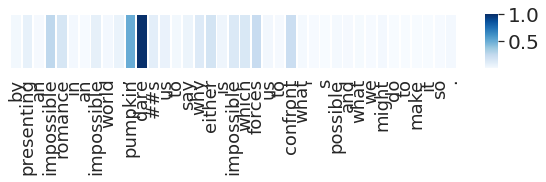

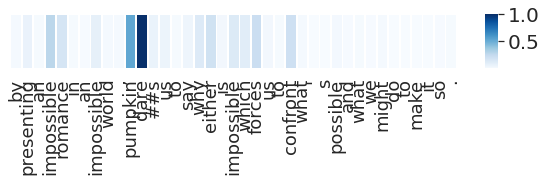

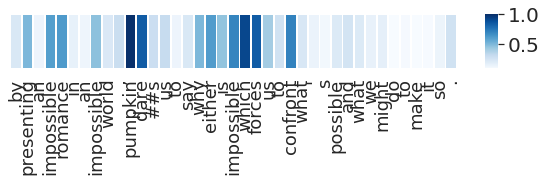

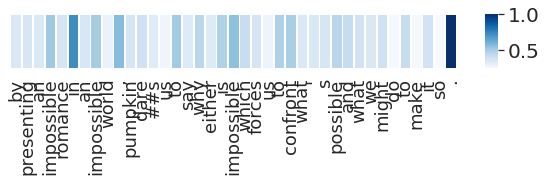

In [264]:
plot_sentence_heatmaps(sst5_attribution_meta)

### Exp. 3.2.2 Word deletion experiments

In [277]:
from random import randrange

def random_drop(input_ids_to_copy, seq_lens, k=1):
    input_ids = input_ids_to_copy.clone()
    for b in range(input_ids.shape[0]):
        if k > seq_lens[b][0]-2:
            input_ids[b] = 0. # zero out all of them
        else:
            zero_out_idx = random.sample(range(1, seq_lens[b][0]), k)
            for idx in zero_out_idx:
                input_ids[b][idx] = 0.
    return input_ids

def topk_drop(input_ids_to_copy, scores, new_seq_lens, k=1):
    input_ids = input_ids_to_copy.clone()
    for b in range(input_ids.shape[0]):
        if k > new_seq_lens[b][0]-2:
            input_ids[b] = 0.
        else:
            _, zero_out_idx = torch.topk(scores[b][:new_seq_lens[b]][1:-1], k, dim=-1)
            zero_out_idx = zero_out_idx + 1
            for idx in zero_out_idx:
                input_ids[b][idx] = 0.
    return input_ids

def sentence_filter(seq_lens, min_len=0):
    sel_idx = []
    for b in range(seq_lens.shape[0]):
        if seq_lens[b][0] >= min_len:
            sel_idx.append(b)
    return sel_idx

def evaluate_with_word_deletion(test_dataloader, model, device, label_list, 
                                k=0, del_type="gi", 
                                original_correct=True,
                                min_len=10):

    # we did not exclude gradients, for attribution methods
    model.eval() # this line will deactivate dropouts
    test_loss, test_accuracy = 0, 0
    nb_test_steps, nb_test_examples = 0, 0
    pred_logits = []
    actual = []

    inputs_ids = []
    seqs_lens = []
    
    k_test_accuracy = [0.0]*k

    # we don't need gradient in this case.
    for _, batch in enumerate(tqdm(test_dataloader, desc="Iteration")):
        k_logits = []
        input_ids, input_mask, segment_ids, label_ids, seq_lens = batch
        # truncate to save space and computing resource
        max_seq_lens = max(seq_lens)[0]
        input_ids = input_ids[:,:max_seq_lens]
        input_mask = input_mask[:,:max_seq_lens]
        segment_ids = segment_ids[:,:max_seq_lens]
        
        sel_idx = sentence_filter(seq_lens, min_len=min_len)
        
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        label_ids = label_ids.to(device)
        seq_lens = seq_lens.to(device)

        input_ids = input_ids[sel_idx]
        input_mask = input_mask[sel_idx]
        segment_ids = segment_ids[sel_idx]
        label_ids = label_ids[sel_idx]
        seq_lens = seq_lens[sel_idx]
        
        sensitivity_class = len(label_list) - 1
        
        tmp_test_loss, logits, all_encoder_attention_scores, embedding_output = \
            model(input_ids, segment_ids, input_mask, seq_lens,
                    device=device, labels=label_ids)
        logits_raw = F.softmax(logits, dim=-1)
        logits = logits_raw.detach().cpu().numpy()
        label_ids_raw = label_ids.to('cpu').numpy()
        outputs = np.argmax(logits, axis=1)
        tmp_idx_correct = outputs == label_ids_raw
        tmp_idx_correct = tmp_idx_correct.nonzero()[0]
        tmp_idx_wrong = outputs != label_ids_raw
        tmp_idx_wrong = tmp_idx_wrong.nonzero()[0]

        if original_correct:
            # select only those that correct
            new_input_ids = input_ids[tmp_idx_correct]
            new_segment_ids = segment_ids[tmp_idx_correct]
            new_input_mask = input_mask[tmp_idx_correct]
            new_seq_lens = seq_lens[tmp_idx_correct]
            new_label_ids = label_ids[tmp_idx_correct]
        else:
            # select only those that are wrong
            new_input_ids = input_ids[tmp_idx_wrong]
            new_segment_ids = segment_ids[tmp_idx_wrong]
            new_input_mask = input_mask[tmp_idx_wrong]
            new_seq_lens = seq_lens[tmp_idx_wrong]
            new_label_ids = label_ids[tmp_idx_wrong]
            
        # corner case handling, if this batch contains no examples, we bypass
        if new_input_ids.shape[0] == 0:
            continue

        if k == 0: # no need to drop
            tmp_test_loss, logits, _, _ = \
                model(new_input_ids, new_segment_ids, new_input_mask, new_seq_lens,
                        device=device, labels=new_label_ids)
        else:
            if del_type == "random":
                # Random dropouts
                for k_i in range(0, k):
                    new_input_ids_curr = random_drop(new_input_ids, new_seq_lens, k=k_i+1)
                    tmp_test_loss, logits, _, _ = \
                        model(new_input_ids_curr, new_segment_ids, new_input_mask, new_seq_lens,
                                device=device, labels=new_label_ids)
                    k_logits.append(logits)
            elif del_type == "gs":
                # GS dropouts
                gs_score = torch.zeros(logits.shape)
                gs_score[:, sensitivity_class] = 1.0
                gs_score = model.backward_gradient(gs_score)
                gs_score = torch.norm(gs_score, dim=-1)*torch.norm(gs_score, dim=-1)
                if original_correct:
                    new_gs_score = gs_score[tmp_idx_correct]
                else:
                    new_gs_score = gs_score[tmp_idx_wrong]
                # rerun
                for k_i in range(0, k):
                    new_input_ids_curr = topk_drop(new_input_ids, new_gs_score, new_seq_lens, k=k_i+1)
                    tmp_test_loss, logits, _, _ = \
                        model(new_input_ids_curr, new_segment_ids, new_input_mask, new_seq_lens,
                                device=device, labels=new_label_ids)
                    k_logits.append(logits)
            elif del_type == "gi":
                # GI dropouts
                gi_score = torch.zeros(logits.shape)
                gi_score[:, sensitivity_class] = 1.0
                gi_score = model.backward_gradient_input(gi_score)
                gi_score = torch.norm(gi_score, dim=-1)*torch.norm(gi_score, dim=-1)
                if original_correct:
                    new_gi_score = gi_score[tmp_idx_correct]
                else:
                    new_gi_score = gi_score[tmp_idx_wrong]
                # rerun
                for k_i in range(0, k):
                    new_input_ids_curr = topk_drop(new_input_ids, new_gi_score, new_seq_lens, k=k_i+1)
                    tmp_test_loss, logits, all_encoder_attention_scores, embedding_output = \
                        model(new_input_ids_curr, new_segment_ids, new_input_mask, new_seq_lens,
                                device=device, labels=new_label_ids)
                    k_logits.append(logits)
            elif del_type == "lrp":
                # lrp dropouts
                Rout_mask = torch.zeros((input_ids.shape[0], len(label_list))).to(device)
                Rout_mask[:, sensitivity_class] = 1.0
                relevance_score = logits_raw*Rout_mask
                lrp_score = model.backward_lrp(relevance_score)
                lrp_score = lrp_score.cpu().detach().data
                lrp_score = torch.abs(lrp_score).sum(dim=-1)
                if original_correct:
                    new_lrp_score = lrp_score[tmp_idx_correct]
                else:
                    new_lrp_score = lrp_score[tmp_idx_wrong]
                # rerun
                for k_i in range(0, k):
                    new_input_ids_curr = topk_drop(new_input_ids, new_lrp_score, new_seq_lens, k=k_i+1)
                    tmp_test_loss, logits, _, _ = \
                        model(new_input_ids_curr, new_segment_ids, new_input_mask, new_seq_lens,
                                device=device, labels=new_label_ids)
                    k_logits.append(logits)
            elif del_type == "lat":
                # lat dropouts
                attention_scores = model.backward_lat(input_ids, all_encoder_attention_scores)
                attention_scores = attention_scores.sum(dim=-1)
                if original_correct:
                    new_attention_scores = attention_scores[tmp_idx_correct]
                else:
                    new_attention_scores = attention_scores[tmp_idx_wrong]
                # rerun
                for k_i in range(0, k):
                    new_input_ids_curr = topk_drop(new_input_ids, new_attention_scores, new_seq_lens, k=k_i+1)
                    tmp_test_loss, logits, all_encoder_attention_scores, embedding_output = \
                        model(new_input_ids_curr, new_segment_ids, new_input_mask, new_seq_lens,
                                device=device, labels=new_label_ids)
                    k_logits.append(logits)
        new_label_ids = new_label_ids.to('cpu').numpy()
        for k_i in range(0, k):
            logits = k_logits[k_i]
            logits_raw = F.softmax(logits, dim=-1)
            logits = logits_raw.detach().cpu().numpy()
            outputs = np.argmax(logits, axis=1)
            tmp_test_accuracy=np.sum(outputs == new_label_ids)
            k_test_accuracy[k_i] = k_test_accuracy[k_i] + tmp_test_accuracy

        nb_test_examples += new_input_ids.size(0) # same for all the ks
        nb_test_steps += 1

    for k_i in range(0, k):
        test_accuracy = k_test_accuracy[k_i]
        test_accuracy = test_accuracy / nb_test_examples
        print("Drop words = %s, Accuracy = %.2f"%(k_i+1, test_accuracy))
    
    for k_i in range(0, k):
        test_accuracy = k_test_accuracy[k_i]
        test_accuracy = test_accuracy / nb_test_examples
        print("%.2f"%(test_accuracy))

def word_deletion_task(task_name, device, sentence_limit=2000, 
                       k=0, del_type="random",
                       original_correct=True):
    """
    We need to set a limit otherwise it takes too long!
    """
    TASK_NAME = task_name
    lrp_data_dir = "../../results"
    vocab_data_dir = "../../models/BERT-Google/vocab.txt"
    DATA_DIR = "../../datasets/" + TASK_NAME + "/"

    # "../../data/uncased_L-12_H-768_A-12/" is for the default BERT-base pretrain
    BERT_PATH = "../../models/BERT-Google/"
    MODEL_PATH = "../../results/" + TASK_NAME + "/best_checkpoint.bin"
    EVAL_BATCH_SIZE = 24 # you can tune this down depends on GPU you have.

    # This loads the task processor for you.
    processors = {
        "SST5": SST5_Processor,
        "SemEval" : SemEval_Processor,
        "IMDb" : IMDb_Processor,
        "Yelp5" : Yelp5_Processor
    }

    processor = processors[TASK_NAME]()
    label_list = processor.get_labels()
    
    model, tokenizer, optimizer = \
        load_model_setups(vocab_file=BERT_PATH + "vocab.txt",
                           bert_config_file=BERT_PATH + "bert_config.json",
                           init_checkpoint=MODEL_PATH,
                           label_list=label_list,
                           num_train_steps=20,
                           do_lower_case=True,
                           # below is not required for eval
                           learning_rate=2e-5,
                           warmup_proportion=0.1,
                           init_lrp=True)
    model = model.to(device) # send the model to device
    
    test_examples = processor.get_test_examples(DATA_DIR, sentence_limit=sentence_limit)
    test_features = \
        convert_examples_to_features(
            test_examples,
            label_list,
            128,
            tokenizer)

    all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in test_features], dtype=torch.long)
    all_seq_len = torch.tensor([[f.seq_len] for f in test_features], dtype=torch.long)

    test_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                              all_label_ids, all_seq_len)

    test_dataloader = DataLoader(test_data, batch_size=EVAL_BATCH_SIZE, shuffle=False)
    
    evaluate_with_word_deletion(test_dataloader, model, device, label_list, 
                                k=k, del_type=del_type, 
                                original_correct=original_correct)

In [283]:
# processors = {
#     "SST5": SST5_Processor,
#     "SemEval" : SemEval_Processor,
#     "IMDb" : IMDb_Processor,
#     "Yelp5" : Yelp5_Processor
# }
i = 10
print("===== Word Deletion with Max K=%s ====="%(i))
word_deletion_task("Yelp5", device, sentence_limit=1000, 
                   k=i, del_type="random", 
                   original_correct=True)

12/29/2020 15:00:20 - INFO - run_classifier -   model = BERT
12/29/2020 15:00:20 - INFO - run_classifier -   *** Model Config ***
12/29/2020 15:00:20 - INFO - run_classifier -   {
  "attention_probs_dropout_prob": 0.1,
  "full_pooler": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



===== Word Deletion with Max K=10 =====
init_weight = True
init_lrp = True


  5%|▍         | 47/1001 [00:00<00:02, 465.32it/s]

sentence limit= 1000
0
guid= test-0
text_a= Don't waste your time.  We had two different people come to our house to give us estimates for a deck (one of them the OWNER).  Both times, we never heard from them.  Not a call, not the estimate, nothing.
text_b= None
label= 0


Iteration: 100%|██████████| 42/42 [02:44<00:00,  3.91s/it]

Drop words = 1, Accuracy = 0.98
Drop words = 2, Accuracy = 0.97
Drop words = 3, Accuracy = 0.95
Drop words = 4, Accuracy = 0.93
Drop words = 5, Accuracy = 0.92
Drop words = 6, Accuracy = 0.88
Drop words = 7, Accuracy = 0.89
Drop words = 8, Accuracy = 0.88
Drop words = 9, Accuracy = 0.86
Drop words = 10, Accuracy = 0.83
0.98
0.97
0.95
0.93
0.92
0.88
0.89
0.88
0.86
0.83


In [284]:
i = 10
print("===== Word Deletion with Max K=%s ====="%(i))
word_deletion_task("Yelp5", device, sentence_limit=1000, 
                   k=i, del_type="gs", 
                   original_correct=True)

12/29/2020 15:03:08 - INFO - run_classifier -   model = BERT
12/29/2020 15:03:08 - INFO - run_classifier -   *** Model Config ***
12/29/2020 15:03:08 - INFO - run_classifier -   {
  "attention_probs_dropout_prob": 0.1,
  "full_pooler": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



===== Word Deletion with Max K=10 =====
init_weight = True
init_lrp = True


  5%|▌         | 54/1001 [00:00<00:01, 535.65it/s]

sentence limit= 1000
0
guid= test-0
text_a= Don't waste your time.  We had two different people come to our house to give us estimates for a deck (one of them the OWNER).  Both times, we never heard from them.  Not a call, not the estimate, nothing.
text_b= None
label= 0


Iteration: 100%|██████████| 42/42 [03:25<00:00,  4.90s/it]

Drop words = 1, Accuracy = 0.87
Drop words = 2, Accuracy = 0.83
Drop words = 3, Accuracy = 0.79
Drop words = 4, Accuracy = 0.75
Drop words = 5, Accuracy = 0.75
Drop words = 6, Accuracy = 0.71
Drop words = 7, Accuracy = 0.70
Drop words = 8, Accuracy = 0.68
Drop words = 9, Accuracy = 0.65
Drop words = 10, Accuracy = 0.64
0.87
0.83
0.79
0.75
0.75
0.71
0.70
0.68
0.65
0.64


In [285]:
i = 10
print("===== Word Deletion with Max K=%s ====="%(i))
word_deletion_task("Yelp5", device, sentence_limit=1000, 
                   k=i, del_type="gi", 
                   original_correct=True)

12/29/2020 15:06:38 - INFO - run_classifier -   model = BERT
12/29/2020 15:06:38 - INFO - run_classifier -   *** Model Config ***
12/29/2020 15:06:38 - INFO - run_classifier -   {
  "attention_probs_dropout_prob": 0.1,
  "full_pooler": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



===== Word Deletion with Max K=10 =====
init_weight = True
init_lrp = True


  6%|▌         | 56/1001 [00:00<00:01, 557.73it/s]

sentence limit= 1000
0
guid= test-0
text_a= Don't waste your time.  We had two different people come to our house to give us estimates for a deck (one of them the OWNER).  Both times, we never heard from them.  Not a call, not the estimate, nothing.
text_b= None
label= 0


Iteration: 100%|██████████| 42/42 [03:26<00:00,  4.91s/it]

Drop words = 1, Accuracy = 0.88
Drop words = 2, Accuracy = 0.82
Drop words = 3, Accuracy = 0.79
Drop words = 4, Accuracy = 0.76
Drop words = 5, Accuracy = 0.75
Drop words = 6, Accuracy = 0.72
Drop words = 7, Accuracy = 0.70
Drop words = 8, Accuracy = 0.68
Drop words = 9, Accuracy = 0.66
Drop words = 10, Accuracy = 0.66
0.88
0.82
0.79
0.76
0.75
0.72
0.70
0.68
0.66
0.66


In [286]:
i = 10
print("===== Word Deletion with Max K=%s ====="%(i))
word_deletion_task("Yelp5", device, sentence_limit=1000, 
                   k=i, del_type="lrp", 
                   original_correct=True)

12/29/2020 15:10:07 - INFO - run_classifier -   model = BERT
12/29/2020 15:10:07 - INFO - run_classifier -   *** Model Config ***
12/29/2020 15:10:07 - INFO - run_classifier -   {
  "attention_probs_dropout_prob": 0.1,
  "full_pooler": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



===== Word Deletion with Max K=10 =====
init_weight = True
init_lrp = True


  5%|▍         | 48/1001 [00:00<00:01, 477.18it/s]

sentence limit= 1000
0
guid= test-0
text_a= Don't waste your time.  We had two different people come to our house to give us estimates for a deck (one of them the OWNER).  Both times, we never heard from them.  Not a call, not the estimate, nothing.
text_b= None
label= 0


Iteration: 100%|██████████| 42/42 [04:47<00:00,  6.84s/it]

Drop words = 1, Accuracy = 0.91
Drop words = 2, Accuracy = 0.86
Drop words = 3, Accuracy = 0.83
Drop words = 4, Accuracy = 0.81
Drop words = 5, Accuracy = 0.78
Drop words = 6, Accuracy = 0.77
Drop words = 7, Accuracy = 0.74
Drop words = 8, Accuracy = 0.71
Drop words = 9, Accuracy = 0.69
Drop words = 10, Accuracy = 0.68
0.91
0.86
0.83
0.81
0.78
0.77
0.74
0.71
0.69
0.68


In [287]:
i = 10
print("===== Word Deletion with Max K=%s ====="%(i))
word_deletion_task("Yelp5", device, sentence_limit=1000, 
                   k=i, del_type="lat", 
                   original_correct=True)

12/29/2020 15:14:58 - INFO - run_classifier -   model = BERT
12/29/2020 15:14:58 - INFO - run_classifier -   *** Model Config ***
12/29/2020 15:14:58 - INFO - run_classifier -   {
  "attention_probs_dropout_prob": 0.1,
  "full_pooler": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



===== Word Deletion with Max K=10 =====
init_weight = True
init_lrp = True


  5%|▌         | 51/1001 [00:00<00:01, 509.59it/s]

sentence limit= 1000
0
guid= test-0
text_a= Don't waste your time.  We had two different people come to our house to give us estimates for a deck (one of them the OWNER).  Both times, we never heard from them.  Not a call, not the estimate, nothing.
text_b= None
label= 0


Iteration: 100%|██████████| 42/42 [02:45<00:00,  3.95s/it]

Drop words = 1, Accuracy = 0.99
Drop words = 2, Accuracy = 0.96
Drop words = 3, Accuracy = 0.95
Drop words = 4, Accuracy = 0.93
Drop words = 5, Accuracy = 0.92
Drop words = 6, Accuracy = 0.90
Drop words = 7, Accuracy = 0.88
Drop words = 8, Accuracy = 0.87
Drop words = 9, Accuracy = 0.85
Drop words = 10, Accuracy = 0.83
0.99
0.96
0.95
0.93
0.92
0.90
0.88
0.87
0.85
0.83


### Exp. 3.4 Correlations across datasets
Due to the memory limitation and cache limitations, we want run these analysis function 1 at a time to avoid failure.

In [ ]:
sst5_dict = analysis_task("SST5", device)
torch.save(sst5_dict, "./sst5_dict.pt")
semeval_dict = analysis_task("SemEval", device)
torch.save(semeval_dict, "./semeval.pt")
imdb_dict = analysis_task("IMDb", device)
torch.save(imdb_dict, "./imdb.pt")
yelp5_dict = analysis_task("Yelp5", device)
torch.save(yelp5_dict, "./yelp5.pt")

In [ ]:
if RETRAIN:
    sst5_dict = analysis_task("SST5", device)
    torch.save(sst5_dict, "./sst5_dict.pt")
    semeval_dict = analysis_task("SemEval", device)
    torch.save(semeval_dict, "./semeval.pt")
    imdb_dict = analysis_task("IMDb", device)
    torch.save(imdb_dict, "./imdb.pt")
    yelp5_dict = analysis_task("Yelp5", device)
    torch.save(yelp5_dict, "./yelp5.pt")
else:
    sst5_dict = torch.load("./sst5_dict.pt")
    semeval_dict = torch.load("./semeval.pt")
    imdb_dict = torch.load("./imdb.pt")
    yelp5_dict = torch.load("./yelp5.pt")

In [ ]:
sst5_word_to_score = load_word_score(vocab_data_dir, 
                                     sst5_dict["inputs_ids"], 
                                     sst5_dict["seqs_lens"],
                                     sst5_dict["grad_scores"])
semeval_word_to_score = load_word_score(vocab_data_dir, 
                                     semeval_dict["inputs_ids"], 
                                     semeval_dict["seqs_lens"],
                                     semeval_dict["grad_scores"])
imdb_word_to_score = load_word_score(vocab_data_dir, 
                                     imdb_dict["inputs_ids"], 
                                     imdb_dict["seqs_lens"],
                                     imdb_dict["grad_scores"])
yelp5_word_to_score = load_word_score(vocab_data_dir, 
                                     yelp5_dict["inputs_ids"], 
                                     yelp5_dict["seqs_lens"],
                                     yelp5_dict["grad_scores"])

In [ ]:
score_list = subset_score([sst5_word_to_score, semeval_word_to_score, imdb_word_to_score, yelp5_word_to_score])
score_df = pd.DataFrame({"sst5": sst5_word_to_score, "semeval": semeval_word_to_score,
                         "imdb": imdb_word_to_score, "yelp5": yelp5_word_to_score})

In [ ]:
score_df[:10]

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = "black"

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plt.rcParams["font.family"] = "Times New Roman"

y = score_list[1]
x = score_list[0]

plt.scatter(x, y, marker='*', color='r')
plt.tight_layout()
plt.grid(color='black', linestyle='-.')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black')


In [ ]:
from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center', size=30)
    ax.set_axis_off()

g = sns.PairGrid(score_df)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot, marker="+", line_kws={"color": "red"})
g.map_upper(reg_coef)